<a href="https://colab.research.google.com/github/avicomputersolutions/Image-Classification-using-QNN/blob/main/Quantum_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output
!pip install -q tensorflow==2.3.1

In [ ]:
!pip install -q tensorflow_quantum==0.4.0

In [ ]:
!pip install cirq==0.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow_quantum as tfq
import cirq as criq
import sympy
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt


In [ ]:
from tensorflow.keras.datasets import fashion_mnist as dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = dataset.load_data()

In [ ]:
print("Shape of x train data is {}".format(x_train.shape))
print("Shape of y_train data is {}".format(y_train.shape))
print("Shape of x_test data is {}".format(x_test.shape))
print("Shape of y_test data is {}".format(y_test.shape))

Shape of x train data is (60000, 28, 28)
Shape of y_train data is (60000,)
Shape of x_test data is (10000, 28, 28)
Shape of y_test data is (10000,)


Preprocessing Datasets


In [ ]:
def filter_data(x,y):

  keep= (y==3)| (y==7)
  x,y= x[keep], y[keep]

  y=y==3
  return x,y

In [ ]:
X_train, Y_train = filter_data(x_train,y_train)

X_test, Y_test = filter_data(x_test,y_test)

In [ ]:
print("Shape of x train data is {}".format(X_train.shape))
print("Shape of y_train data is {}".format(Y_train.shape))
print("Shape of x_test data is {}".format(X_test.shape))
print("Shape of y_test data is {}".format(Y_test.shape))

Shape of x train data is (12000, 28, 28)
Shape of y_train data is (12000,)
Shape of x_test data is (2000, 28, 28)
Shape of y_test data is (2000,)


The first image has the label True


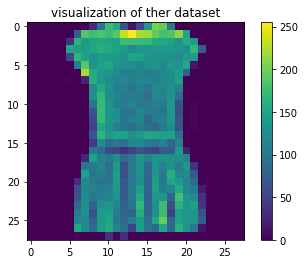

In [ ]:
print("The first image has the label {}".format(Y_train[0]))
plt.imshow(X_train[0])
plt.colorbar()
plt.title("visualization of ther dataset")
plt.show()

In [ ]:
X_train= X_train.reshape(X_train.shape[0],*(28,28,1))
X_test= X_test.reshape(X_test.shape[0],*(28,28,1))

In [ ]:
X_train= tf.image.resize(X_train,(2,2)).numpy()
X_test= tf.image.resize(X_test,(2,2)).numpy()

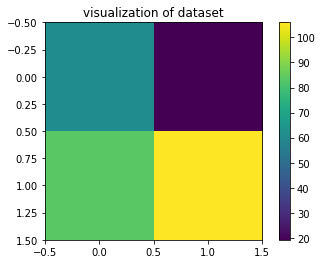

In [ ]:
plt.imshow(X_train[0,:,:,0])
plt.colorbar()
plt.title("visualization of dataset")
plt.show()

In [ ]:
print("Shape of x train data is {}".format(X_train.shape))
print("Shape of y_train data is {}".format(Y_train.shape))


Shape of x train data is (12000, 2, 2, 1)
Shape of y_train data is (12000,)


Data Encoding


In [ ]:
X_train= X_train.reshape(X_train.shape[0],*(1,4,1) )

X_test= X_test.reshape(X_test.shape[0],*(1,4,1) )

In [ ]:
print(X_train[0])

[[[ 61.5 ]
  [ 19.25]
  [ 83.75]
  [106.  ]]]


In [ ]:
def binary_encode(x, threshold=0.5):
  
  encoded_images=list()
  for image in x:
    encoded_image= [1 if j > threshold else 0 for j in image[0]]
    encoded_images.append(encoded_image)
  return np.array(encoded_images)

In [ ]:
X_train= binary_encode(X_train)

X_test= binary_encode(X_test)

In [ ]:
print(X_train[0])

[1 1 1 1]


In [ ]:
print(X_train.shape)

(12000, 4)


In [ ]:
def create_circuit_from_image(encoded_image):
  qubits= criq.GridQubit.rect(2,2)
  circuit= criq.Circuit()
  for i, pixel in enumerate(encoded_image):
    if pixel:
      circuit.append(criq.X(qubits[i]))
  return circuit

In [ ]:
X_train= [create_circuit_from_image(encoded_image) for encoded_image in X_train]

X_test= [create_circuit_from_image(encoded_image) for encoded_image in X_test]
X_train[0]

(0, 0): ───X───

(0, 1): ───X───

(1, 0): ───X───

(1, 1): ───X───

In [ ]:
X_train_tfq=tfq.convert_to_tensor(X_train)

X_test_tfq=tfq.convert_to_tensor(X_test)

In [ ]:
class QNN():
  def __init__(self,data_qubits,readout):
    self.data_qubits=data_qubits
    self.readout=readout
  
  def add_singleQubit_gate(self, circuit,gate,qubit_index):
    for index in qubit_index:
      circuit.append(gate(self.data_qubit[index]))
  
  def add_twoQubit_gate(self,circuit,gate,qubit_index):
    if len(qubit_index)!=2:
      raise Exception("the length of the list of indices passed for two qubit/gate operation must be  equal to two")
      circuit.append(gate(self.data_qubits[qubit_index[0]],self.data_qubits[qubit_index[1]]))
  
  def add_layer(self, circuit,gate,symbol_gate):
    for i, qubit in enumerate(self.data_qubits):
      symbol=sympy.Symbol(symbol_gate +'_'+str(i))
      circuit.append(gate(qubit,self.readout)**symbol)

In [ ]:
def create_qnn():
  data_qubits=criq.GridQubit.rect(2,2)
  readout= criq.GridQubit(-1,-1)
  circuit=criq.Circuit()
  circuit.append(criq.X(readout))
  circuit.append(criq.H(readout))
  qnn=QNN(data_qubits=data_qubits, readout=readout)
  qnn.add_layer(circuit,criq.XX,'xx')
  qnn.add_layer(circuit,criq.ZZ,'zz')
  circuit.append(criq.H(readout))
  
  return circuit, criq.Z(readout)

In [ ]:
qmodel,model_readout=create_qnn()


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


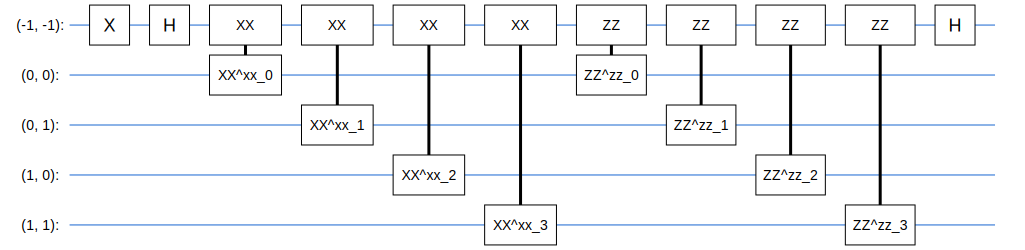

In [ ]:
SVGCircuit(qmodel)

In [ ]:
model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(qmodel,model_readout)
])

In [ ]:
Y_train_h=np.array([1 if i==1 else -1 for i in Y_train])

Y_test_h=np.array([1 if i==1 else -1 for i in Y_test])

In [ ]:
def hinge_accuracy(y_true, y_pred):
  y_true=tf.squeeze(y_true) > 0.0
  y_pred=tf.squeeze(y_pred) > 0.0
  result=tf.cast(y_true == y_pred,tf.float32)
  return tf.reduce_mean(result)

In [ ]:
model.compile(loss=tf.keras.losses.Hinge(),
              optimizer=tf.keras.optimizers.RMSprop(lr=0.001,  momentum=0.9, ),
              metrics=[hinge_accuracy])

In [ ]:
history=model.fit(X_train_tfq,Y_train_h,
                       batch_size=8,
                       epochs=20,
                   validation_split=0.3,
                       verbose=1
                       )

Epoch 1/20
1050/1050 [==============================] - 10s 10ms/step - loss: 0.6838 - hinge_accuracy: 0.6832 - val_loss: 0.6894 - val_hinge_accuracy: 0.6983
Epoch 2/20
1050/1050 [==============================] - 9s 9ms/step - loss: 0.6839 - hinge_accuracy: 0.6870 - val_loss: 0.6906 - val_hinge_accuracy: 0.6983
Epoch 3/20
1050/1050 [==============================] - 9s 9ms/step - loss: 0.6820 - hinge_accuracy: 0.6846 - val_loss: 0.6926 - val_hinge_accuracy: 0.6983
Epoch 4/20
1050/1050 [==============================] - 9s 9ms/step - loss: 0.6833 - hinge_accuracy: 0.6832 - val_loss: 0.6909 - val_hinge_accuracy: 0.6983
Epoch 5/20
1050/1050 [==============================] - 9s 8ms/step - loss: 0.6824 - hinge_accuracy: 0.6843 - val_loss: 0.6920 - val_hinge_accuracy: 0.6983
Epoch 6/20
1050/1050 [==============================] - 9s 8ms/step - loss: 0.6821 - hinge_accuracy: 0.6893 - val_loss: 0.6952 - val_hinge_accuracy: 0.6503
Epoch 7/20
1050/1050 [==============================] - 9s 8ms

In [ ]:
model.evaluate(X_test_tfq,Y_test_h)


63/63 [==============================] - 1s 18ms/step - loss: 0.6773 - hinge_accuracy: 0.7054


[0.6773092150688171, 0.7053571343421936]

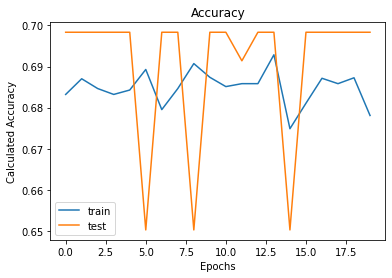

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['hinge_accuracy'], label='train')
plt.plot(history.history['val_hinge_accuracy'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Calculated Accuracy')
plt.legend()
plt.show()

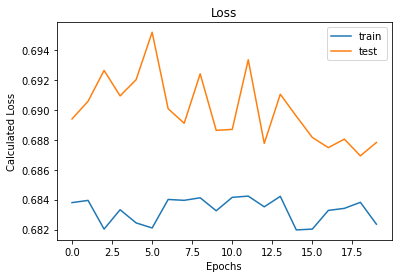

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Calculated Loss')
plt.legend()
plt.show()